In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("assignment_3_dataset.csv")




    subject ID (person), 
    programming language (lang), 
    run time for z1000 input file in minutes (z1000t), 
    run time for z0 input file in minutes (z0t),
    memory consumption at the end of run for z1000 input file in kilobytes (z1000mem),
    program length in statement lines of code (stmtL), 
    output reliability for z1000 input file in percent (z1000rel), 
    output reliability for m1000 input file in percent (m1000rel), 
    total subject work time in hours (whours), 
    subject’s answer to the capability question “I consider myself to be among the top X percent of all programmers” (caps).


In [2]:
df.head()

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,0,s018,c,0.017,0.017,22432,16.1,98.10,96.8,16.1,??
1,1,s030,C,NaN,0.033,16968,4.0,76.47,92.1,4.0,??
2,2,s036,c,20.900,0.000,11440,8.2,0.00,89.5,8.2,??
3,3,s066,C,0.750,0.467,2952,7.3,98.48,100.0,7.3,??
4,4,s078,c,0.050,0.050,22496,10.9,99.24,98.4,10.9,??


## Cleaning and normalization 
---
1. The 'caps' column has "??" and emtpy values which are normalized to not answered
2. Fixing 'lang' spelling inconsistencies with capital and non capital spellings.
3. Fixing empty cells in "z1000t" where empty cells should be 0, Converting all values to floats & rounding to 3 decimals.
4. Fixing empty cells in "stmlL" empty cells to *not answered*, and rounding all values upwards and into ints. Since you can't have 0 lines of code or 0.4 lines of code.
5. For both "z1000rel" and "m1000rel" normalized to make all value float with 2 decimals.
6. For "whours" for each missing cell set a 0, also use consistancy and use floats with 1 decimal for all values.

In [3]:
# 1. Caps has ?? and empty values 

na = "not answered"

df['caps'] = df['caps'].replace("??", na)
df['caps'] = df['caps'].replace("", na)
df['caps'] = df['caps'].fillna(na) 

#Verfication 
df['caps'].value_counts(dropna=False)

caps
not answered    42
10-25%          15
0-10%           14
25-40%           4
40-60%           3
60-75%           2
Name: count, dtype: int64

In [4]:
# 2.Lang has spelling inconsistencies with captial and non capital letters


df['lang'].replace({
    "c": "C",
    "c++": "C++",
    "java": "Java",
    "perl": "Perl",
    "python": "Python",
    "rexx": "Rexx",
    "tcl": "Tcl"
}, inplace=True)


df['lang'].value_counts(dropna=False)


/tmp/ipykernel_91404/2124790157.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['lang'].replace({


lang
Java      24
Python    13
Perl      13
C++       11
Tcl       10
C          5
Rexx       4
Name: count, dtype: int64

In [5]:
#3. "z1000t" empty cells
df['z1000t'] = df['z1000t'].replace("", 0).fillna(0)

# Convert all values to floats 
df['z1000t'] = pd.to_numeric(df['z1000t'], errors='coerce').fillna(0)

#Round to 3 decmial for consistency
df['z1000t'] = df['z1000t'].round(3)

df['z1000t'].value_counts(dropna=False)


z1000t
0.000      5
0.267      5
0.200      4
0.083      3
21.400     2
0.033      2
0.050      2
0.150      2
0.350      2
0.250      2
0.117      2
0.617      2
0.167      2
0.467      2
0.650      2
4.867      1
2.633      1
0.633      1
20.900     1
0.750      1
0.017      1
1.983      1
1.667      1
1.533      1
1.700      1
0.317      1
2.200      1
6.467      1
0.283      1
0.917      1
1.333      1
4.150      1
30.100     1
31.200     1
1.467      1
37.100     1
0.483      1
67.500     1
3.783      1
16.800     1
1.583      1
0.333      1
0.133      1
0.183      1
0.450      1
72.300     1
0.733      1
0.817      1
25.400     1
21.000     1
0.567      1
0.967      1
0.783      1
202.800    1
0.683      1
29.400     1
Name: count, dtype: int64

In [39]:
# stml 

df['stmtL'] = df['stmtL'].replace('', np.nan)

df['stmtL'] = df['stmtL'].fillna("not answered")

df['stmtL_numeric'] = pd.to_numeric(df['stmtL'], errors='coerce')

df['stmtL_numeric'] = np.ceil(df['stmtL_numeric'])

df['stmtL_numeric'] = df['stmtL_numeric'].fillna("not answered")

df['stmtL'] = df['stmtL_numeric'].astype(str)
df = df.drop(columns=['stmtL_numeric'])

df['stmtL'].value_counts(dropna=False)



stmtL
4.0             9
2.0             9
5.0             8
3.0             7
8.0             6
7.0             6
10.0            3
not answered    3
9.0             3
1.0             3
11.0            2
20.0            2
12.0            2
13.0            2
16.0            1
26.0            1
17.0            1
49.0            1
19.0            1
64.0            1
14.0            1
40.0            1
131342.0        1
18.0            1
0.0             1
27.0            1
43637.0         1
6.0             1
34632.0         1
Name: count, dtype: int64

In [40]:
# === z1000rel === 

# Convert all values to floats 
df['z1000rel'] = pd.to_numeric(df['z1000rel'], errors='coerce').fillna(0)

#Round to 3 decmial for consistency
df['z1000rel'] = df['z1000rel'].round(2)


# === m1000rel === #

# Convert all values to floats 
df['m1000rel'] = pd.to_numeric(df['m1000rel'], errors='coerce').fillna(0)

#Round to 3 decmial for consistency
df['m1000rel'] = df['m1000rel'].round(2)

df['z1000rel'].value_counts(dropna=False)


df['m1000rel'].value_counts(dropna=False)

m1000rel
100.0    37
10.2     15
98.4     14
0.0       3
89.5      1
96.8      1
92.1      1
1.1       1
90.9      1
96.3      1
10.1      1
97.9      1
6.6       1
46.6      1
98.9      1
Name: count, dtype: int64

In [41]:
# whours 

df['whours'] = df['whours'].fillna(0) 

df['whours'] = pd.to_numeric(df['whours'], errors='coerce').fillna(0)

#Round to 3 decmial for consistency
df['whours'] = df['whours'].round(1)

df['whours'].value_counts(dropna=False)

whours
0.0         4
3.0         3
7.0         3
3.8         3
3.5         2
7.3         2
5.0         2
13.0        2
6.2         2
4.8         2
4.0         2
8.2         2
1.6         2
2.8         2
4.5         2
25.3        1
7.5         1
10.1        1
11.9        1
15.2        1
48.9        1
7.1         1
8.7         1
10.9        1
6.9         1
19.6        1
16.1        1
11.2        1
7.4         1
17.8        1
18.1        1
13.8        1
63.2        1
9.7         1
26.6        1
131342.0    1
9.8         1
19.7        1
1.7         1
1.1         1
3.2         1
2.5         1
39.7        1
43637.0     1
1.0         1
3.7         1
2.0         1
1.2         1
2.4         1
1.5         1
5.5         1
1.8         1
4.2         1
4.3         1
0.9         1
8.0         1
10.0        1
34632.0     1
1.4         1
0.6         1
Name: count, dtype: int64

In [25]:
# Remove the outliers as they are deemed as misstake values

#For each with exessive whours they have the same amount in stmL 

# Pick theese and list them

outliers = df[
    (df["stmtL"] == df["whours"]) &
    (df["stmtL"] >= 34632)
]

outliers

df["stmtL"].describe()




count        77.000000
mean       2730.601818
std       16132.743573
min           0.000000
25%           3.000000
50%           6.170000
75%          10.900000
max      131342.000000
Name: stmtL, dtype: float64

In [28]:
print((34632 / 40) / 52)

16.65


## Exploratory Data Analysis

---

- Take avereage lines of code per language and avreage workhours and compare 

In [42]:
df

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,0,s018,C,0.017,0.017,22432,17.0,98.10,96.8,16.1,not answered
1,1,s030,C,0.000,0.033,16968,4.0,76.47,92.1,4.0,not answered
2,2,s036,C,20.900,0.000,11440,9.0,0.00,89.5,8.2,not answered
3,3,s066,C,0.750,0.467,2952,8.0,98.48,100.0,7.3,not answered
4,4,s078,C,0.050,0.050,22496,11.0,99.24,98.4,10.9,not answered
...,...,...,...,...,...,...,...,...,...,...,...
75,75,s149407,Tcl,0.783,0.467,17672,1.0,100.00,100.0,0.6,0-10%
76,76,s149408,Tcl,202.800,0.633,48840,7.0,100.00,100.0,7.0,0-10%
77,77,s149409,Tcl,0.683,0.567,23192,not answered,100.00,100.0,0.0,0-10%
78,78,s149410,Tcl,29.400,1.433,20296,13.0,100.00,10.2,13.0,40-60%


In [50]:
df['stmtL'] = pd.to_numeric(df['stmtL'], errors='coerce')

# Group by language and calculate the mean
lang_summary = df.groupby('lang')[['stmtL', 'whours']].mean()

lang_summary

,stmtL,whours
lang,,
C,9.800000,9.300000
C++,11.900000,10.381818
Java,7305.416667,7305.066667
Perl,3.769231,3.384615
Python,3.583333,2.953846
Rexx,5.500000,5.475000
Tcl,3852.444444,3466.980000


This shows the tha avereage lines of code and avereage workhours spent per language where we also can see that Java and TCL have significantly larger work hours and large code bases. We can also se a correlation between lines of code and work hours. 



In [48]:
# Exlude outliers
stmtL_cutoff = 131342
whours_cutoff = 34632

# Filter out extreme outliers
filtered_df = df[(df['stmtL'] < stmtL_cutoff) & (df['whours'] < whours_cutoff)]

# Recalculate means without outliers
filtered_summary = filtered_df.groupby('lang')[['stmtL', 'whours']].mean()

filtered_summary

,stmtL,whours
lang,,
C,9.800000,9.300000
C++,11.900000,11.420000
Java,15.954545,15.572727
Perl,3.769231,3.384615
Python,3.583333,3.200000
Rexx,5.500000,5.475000
Tcl,5.000000,4.725000


Exluding the outliers gives a bit more comparable data to the other progamming languages. 

In [51]:
df[['stmtL', 'whours']].describe()


,stmtL,whours
count,77.000000,80.000000
mean,2730.961039,2628.205000
std,16132.682195,15832.070071
min,0.000000,0.000000
25%,3.000000,2.950000
50%,7.000000,5.250000
75%,11.000000,10.300000
max,131342.000000,131342.000000


## Correlation Analysis

---

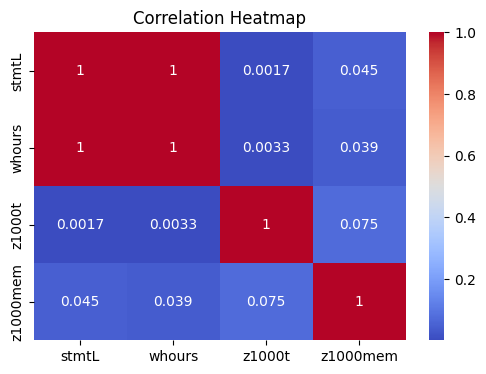

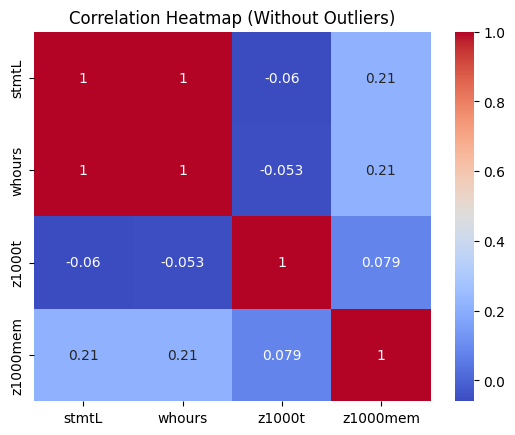

In [58]:

corr = df[['stmtL', 'whours', 'z1000t', 'z1000mem']].corr(method='pearson')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

corr_filtered = filtered_df[['stmtL', 'whours', 'z1000t', 'z1000mem']].corr(method='pearson')
sns.heatmap(corr_filtered, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Without Outliers)')
plt.show()


| Pearson correlation coefficient (r) value | Strength  | Direction |
|--------------------------------------------|------------|------------|
| Greater than .5                            | Strong     | Positive   |
| Between .3 and .5                          | Moderate   | Positive   |
| Between 0 and .3                           | Weak       | Positive   |
| 0                                          | None       | None       |
| Between 0 and –.3                          | Weak       | Negative   |
| Between –.3 and –.5                        | Moderate   | Negative   |
| Less than –.5                              | Strong     | Negative   |

- Based on the above table we can see that for both heat maps there is a strong correlation between whours and stmtL.
- Other correlation in both cases are weak. With the difference with the outliers filtered the weak positive correlation become weak negative ones. 

## Hypothesis Testing

---
#### Hypothesis 
1. The more lines of code the more working hours are spent.
2. Individuals whom see themselves as over 60% of programms produce more lines of code per hour.

In [62]:
#1

from scipy.stats import pearsonr

# Drop rows with missing values in either column
clean_df = df[['stmtL', 'whours']].dropna()

pearson_corr, p_val = pearsonr(clean_df['stmtL'], clean_df['whours'])
print(f"Pearson r = {pearson_corr:.3f}, p-value = {p_val:.3f}")


Pearson r = 1.000, p-value = 0.000


In [63]:
#2. 
import scipy.stats as stats

# Create a new column for productivity
df['loc_per_hour'] = df['stmtL'] / df['whours']

# Drop NaN or infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loc_per_hour', 'caps'])

# Group data by caps
groups = [group['loc_per_hour'].values for name, group in df.groupby('caps')]
T
# ANOVA
f_stat, p_val = stats.f_oneway(*groups)
print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.3f}")


F-statistic = 2.924, p-value = 0.019


**Claim: The more lines of code, the more working hours are spent.**

- HO:There is no correlation between lines of code (stmtL) and working hours (whours).
- H1:There is a positive correlation — more lines of code → more hours worked.

Analysis output: Pearson r = 1.000, p-value = 0.000

r = 1.000 which shows a perfect *positive* correlation. This means that as the number of lines of code increases, working hours increas in an almost a perfect linear way. 
since p < 0.05 the resuls is statistically significant. 

**Conclusion**: Reject H0.
There is strong evidence of a perfect positive relationship between lines of code and working hours. In other words, programmers who write more lines of code also spend more time coding. 

---

**Claim: Indiciduals who see themselves as over 60% of programmers produce more lines of code per hour.**

- H0: The mean lines of code per hour (loc_per_hour) are equal acress self-assessed skill levels (caps) 
- H1: At least one group differs in productivty (e.g., those who rate themselves >60% differ from others). 

Analysis output: F-statistic = 2.924, p-value = 0.019

- **F-value** shows some variation between group means and relative to within-group variation.
- **p-value** shows the result is statistically significant.

**Conclusion**: Reject H0.
There is evidence of a difference in productivity (LOC/hour) between self-assessment groups. 
Specifically, those who rate themselves above 60% likely produce more lines of code per hour compared to others. 

